In [ ]:
# Characterisation can be done by changing settings to qibolab/runcards/tiiq.yml and examples/tii/diagnostics.yml
# These scripts do not save the characterisation results to the runcard; to do so use save_config_parameter:
#   ds.backup_config_file()
#   resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy()
#   ds.save_config_parameter('resonator_freq', resonator_freq, 'characterization', 'single_qubit', qubit)

In [1]:
from qibolab.paths import script_folder
from qibolab import Platform
from qibolab.calibration import utils
from qibolab.calibration.calibration import Calibration as Diagnostics

diagnostics_settings = script_folder / "diagnostics.yml"

# Create a platform; connect and configure it
platform = Platform('tiiq')
platform.connect()
platform.setup()

# create a diagnostics/calibration object
ds = Diagnostics(platform, diagnostics_settings)

# select the qubit to be characterised
qubit = 0


[Qibo 0.1.8.dev2|INFO|2022-07-23 03:28:25]: Loading platform tiiq from runcard d:\alvaro\projects\github\qibolab\src\qibolab\runcards\tiiq.yml
[Qibo 0.1.8.dev2|INFO|2022-07-23 03:28:25]: Connecting to tiiq instrument qrm_rf.
[Qibo 0.1.8.dev2|INFO|2022-07-23 03:28:27]: Connecting to tiiq instrument qcm_rf1.
[Qibo 0.1.8.dev2|INFO|2022-07-23 03:28:32]: Creating MeasurementControl Calibration


Resonator Spectroscopy

Starting iterative measurement...
100% completed | elapsed time:     30s | time left:      0s  
100% completed | elapsed time:     30s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     68s | time left:      0s  
100% completed | elapsed time:     68s | time left:      0s  

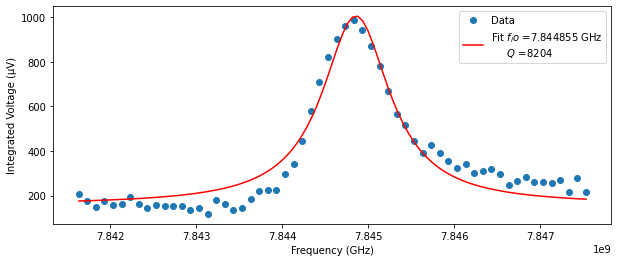


Resonator Frequency = 7864855425


In [3]:
resonator_freq, avg_voltage, peak_voltage, dataset = ds.run_resonator_spectroscopy(qubit)

In [5]:
int(avg_voltage)

251

In [ ]:
ds.save_config_parameter("resonator_freq", resonator_freq, 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("resonator_spectroscopy_avg_ro_voltage", int(avg_voltage), 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("resonator_spectroscopy_peak_ro_voltage", int(peak_voltage), 'characterization', 'single_qubit', qubit)
lo_qrm_frequency = int(resonator_freq - platform.settings['native_gates']['single_qubit'][qubit]['MZ']['frequency'])
ds.save_config_parameter("out0_in0_lo_freq", lo_qrm_frequency, 'instruments', platform.qrm[qubit].name, 'settings')

Resonator Punchout

In [2]:
dataset = ds.run_resonator_punchout(qubit)

Starting iterative measurement...
100% completed | elapsed time:   1184s | time left:      0s  
100% completed | elapsed time:   1184s | time left:      0s  

Resonator Spectroscopy Flux

In [ ]:
dataset = ds.run_resonator_punchout(qubit, fluxline = 0)

Qubit Spectroscopy

Starting iterative measurement...
100% completed | elapsed time:     40s | time left:      0s  
100% completed | elapsed time:     40s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     70s | time left:      0s  
100% completed | elapsed time:     70s | time left:      0s  

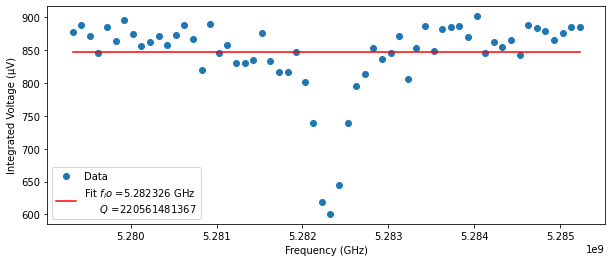


Qubit Frequency = 5082325834


In [12]:
qubit_freq, avg_voltage, peak_voltage, dataset = ds.run_qubit_spectroscopy(qubit)

In [ ]:
ds.save_config_parameter("qubit_freq", qubit_freq, 'characterization', 'single_qubit', qubit)
lo_qcm_frequency = int(qubit_freq + platform.settings['native_gates']['single_qubit'][qubit]['RX']['frequency'])
ds.save_config_parameter("out0_lo_freq", lo_qcm_frequency, 'instruments', platform.lo_qcm[qubit].name, 'settings')
ds.save_config_parameter("qubit_spectroscopy_peak_ro_voltage", float(peak_voltage), 'characterization', 'single_qubit', qubit)

Rabi Oscillations with varying pulse length

Starting iterative measurement...
100% completed | elapsed time:    179s | time left:      0s  
100% completed | elapsed time:    179s | time left:      0s  
Pi pulse duration = 30.076511276303677

Pi pulse amplitude = 0.9

rabi oscillation peak voltage = 418


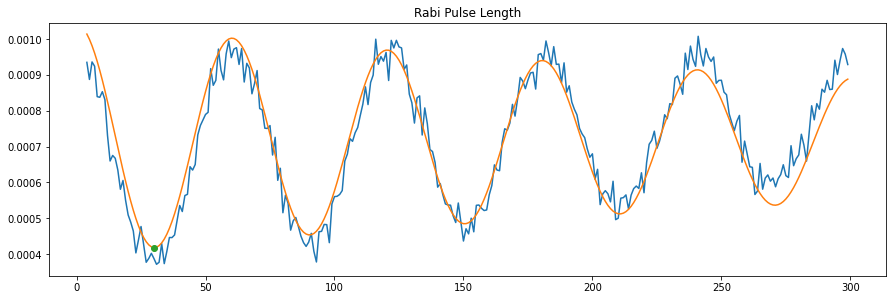

In [12]:
pi_pulse_duration, pi_pulse_amplitude, rabi_oscillations_pi_pulse_peak_ro_voltage, dataset = ds.run_rabi_pulse_length(qubit)

In [ ]:
ds.save_config_parameter("duration", int(pi_pulse_duration), 'native_gates', 'single_qubit', qubit, 'RX')
ds.save_config_parameter("amplitude", float(pi_pulse_amplitude), 'native_gates', 'single_qubit', qubit, 'RX')
ds.save_config_parameter("rabi_oscillations_pi_pulse_peak_ro_voltage", float(rabi_oscillations_pi_pulse_peak_ro_voltage), 'characterization', 'single_qubit', qubit)

Rabi Oscillations with varying pulse gain

In [ ]:
pi_pulse_gain, pi_pulse_amplitude, rabi_oscillations_pi_pulse_peak_voltage, dataset = ds.run_rabi_pulse_gain(qubit)

T1

In [ ]:
t1, dataset = ds.run_t1(qubit)

In [ ]:
ds.save_config_parameter("T1", float(t1), 'characterization', 'single_qubit', qubit)

Ramsey

In [ ]:
delta_frequency, corrected_qubit_frequency, t2, smooth_dataset, dataset = ds.run_ramsey(qubit)

In [ ]:
adjusted_qubit_freq = int(platform.settings['characterization']['single_qubit'][qubit]['qubit_freq'] + delta_frequency)
ds.save_config_parameter("qubit_freq", adjusted_qubit_freq, 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("T2", float(t2), 'characterization', 'single_qubit', qubit)
RX_pulse_sequence = platform.settings['native_gates']['single_qubit'][qubit]['RX']['pulse_sequence']
lo_qcm_frequency = int(adjusted_qubit_freq + RX_pulse_sequence[0]['frequency'])
ds.save_config_parameter("frequency", lo_qcm_frequency, 'instruments', platform.lo_qcm[qubit].name, 'settings')
print(adjusted_qubit_freq)

Dispersive Shift Resonator Spectroscopy

Starting iterative measurement...
100% completed | elapsed time:     78s | time left:      0s  
100% completed | elapsed time:     78s | time left:      0s  

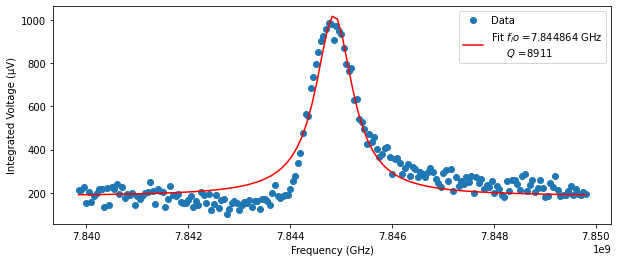

Starting iterative measurement...
100% completed | elapsed time:     83s | time left:      0s  
100% completed | elapsed time:     83s | time left:      0s  

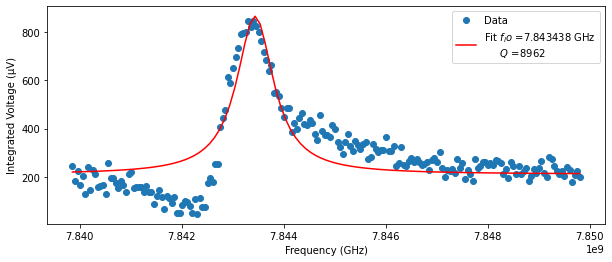


Resonator Frequency = 7864864319

Shifted Frequency = 7863437571

Dispersive Shift = -1426748


In [16]:
shifted_resonator_freq, dispersive_shift, peak_voltage, dataset = ds.run_dispersive_shift(qubit)

Spin Echo

In [ ]:
# Spin Echo: RX(pi/2) - wait t(rotates z) - RX(pi) - wait t(rotates z) - readout
dataset = ds.run_spin_echo(qubit)

In [ ]:
# Spin Echo 3 Pulses: RX(pi/2) - wait t(rotates z) - RX(pi) - wait t(rotates z) - RX(pi/2) - readout
dataset = ds.run_spin_echo_3pulses(qubit)

Qubit states classification

In [6]:
all_gnd_states, mean_gnd_states, all_exc_states, mean_exc_states = ds.calibrate_qubit_states(qubit)

Starting exc state calibration 0
Finished exc single shot execution  0
Starting exc state calibration 1
Finished exc single shot execution  1
Starting exc state calibration 2
Finished exc single shot execution  2
Starting exc state calibration 3
Finished exc single shot execution  3
Starting exc state calibration 4
Finished exc single shot execution  4
Starting exc state calibration 5
Finished exc single shot execution  5
Starting exc state calibration 6
Finished exc single shot execution  6
Starting exc state calibration 7
Finished exc single shot execution  7
Starting exc state calibration 8
Finished exc single shot execution  8
Starting exc state calibration 9
Finished exc single shot execution  9
Starting exc state calibration 10
Finished exc single shot execution  10
Starting exc state calibration 11
Finished exc single shot execution  11
Starting exc state calibration 12
Finished exc single shot execution  12
Starting exc state calibration 13
Finished exc single shot execution  1

In [8]:
mean_gnd_states, mean_exc_states

((-0.0008313786783245074+0.00044815319987281076j),
 (-0.00022773024569023835+0.0003203066357136082j))

[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 

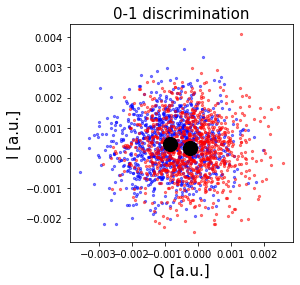

In [9]:
utils.plot_qubit_states(all_gnd_states, all_exc_states)

#Classify all points into 0 and 1
classified_gnd_results = []
for point in all_gnd_states: 
    classified_gnd_results.append(utils.classify(point, mean_gnd_states, mean_exc_states))

classified_exc_results = []
for point in all_exc_states:
    classified_exc_results.append(utils.classify(point, mean_gnd_states, mean_exc_states))

print(classified_gnd_results)
print(classified_exc_results)

allXY

In [2]:
results, gateNumber = ds.allXY(qubit)
print(results)

Transforming to sequence I gate
Transforming to sequence I gate
Transforming to sequence RX(pi) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RY(pi) gate
Transforming to sequence RY(pi) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RY(pi) gate
Transforming to sequence RY(pi) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RX(pi/2) gate
Transforming to sequence I gate
Transforming to sequence RY(pi/2) gate
Transforming to sequence I gate
Transforming to sequence RX(pi/2) gate
Transforming to sequence RY(pi/2) gate
Transforming to sequence RX(pi/2) gate
Transforming to sequence RY(pi/2) gate
Transforming to sequence RX(pi/2) gate
Transforming to sequence RY(pi) gate
Transforming to sequence RY(pi/2) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RY(pi/2) gate
Transforming to sequence RX(pi) gate
Transforming to sequence RX(pi/2) gate
Transforming to sequence RX(pi/2) gate

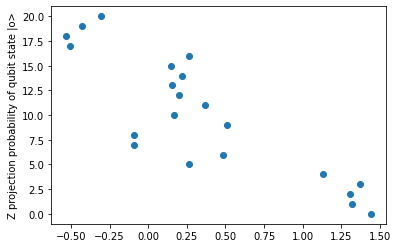

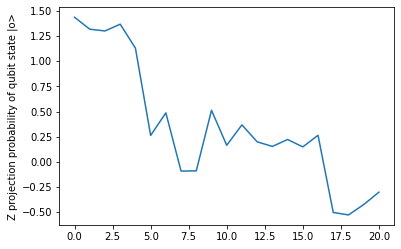

In [3]:
import matplotlib.pyplot as plt

plt.scatter(results, gateNumber)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

plt.plot(results)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

Ramsey freq

In [3]:
t2, last_delta_phys, smooth_dataset, dataset = ds.run_ramsey_freq(qubit)

Starting iterative measurement...
100% completed | elapsed time:     42s | time left:      0s  
100% completed | elapsed time:     42s | time left:      0s  